In [1]:
# Packages
using Knet, AutoGrad, LinearAlgebra, Base.Iterators, Statistics, Random, StatsBase, IterTools, Plots

In [2]:
# Constants
ENV["COLUMNS"] = 64
ARRAY=Array{Float64} # KnetArray{Float32}
UPDATE=true # keep this true (false only useful for checking gradients)
BSIZE=1     # keep batchsize=1 until larger ones supported
XSIZE=28*28
YSIZE=10
HSIZE=[64]
ALPHA=100.0
GAMMA=0.1
LAMBDA=0.995
ETA=0.1
MU0=0.0001

0.0001

In [3]:
# Load minibatched MNIST data:
include(Knet.dir("data","mnist.jl"))
dtrn, dtst = mnistdata(xtype=ARRAY, batchsize=BSIZE)
xtrn, ytrn, xtst, ytst = mnist()
xtrn = ARRAY(reshape(xtrn,(XSIZE,:)))
xtst = ARRAY(reshape(xtst,(XSIZE,:)));

┌ Info: Loading MNIST...
└ @ Main /home/deniz/.julia/dev/Knet/data/mnist.jl:33


In [4]:
# Model definition and initialization
struct MLP; W; b; μ; B; ∇g;
    function MLP(dims...;α=ALPHA)
        h,o = dims[end-1:end]
        W = initw.(dims[1:end-1],dims[2:end])
        b = initb.(dims[2:end])
        μ = initμ(h,o)
        B = initB(h,o;α=α)
        ∇g = init∇g(h)
        new(W, b, μ, B, ∇g)
    end
end

initw(i,o)=Param(ARRAY(xavier(o,i)))
initb(o)=Param(ARRAY(zeros(o)))
initμ(h,o)=ARRAY(MU0*randn(h,o))
initB(h,o;α=ALPHA)=(B = zeros(h,h,o); for i in 1:o, j in 1:h; B[j,j,i] = α; end; ARRAY(B))
init∇g(h)=ARRAY(zeros(h))

Base.show(io::IO, m::MLP)=print(IOContext(io,:compact=>true), "MLP", (size(m.W[1],2),length.(m.b)...))

In [5]:
# Featurevec, predict and loss functions
function featurevector(m::MLP,x)
    L,y = length(m.W),mat(x)
    for l in 1:L-1
        y = relu.(m.b[l] .+ m.W[l] * y)
    end
    return y
end

function (m::MLP)(x) # predict
    m.b[end] .+ m.W[end] * featurevector(m,x)
end

function (m::MLP)(x,labels;γ=GAMMA) # loss
    @assert length(labels)==1 "Batchsize > 1 not implemented yet."
    yfeat = featurevector(m,x)
    ypred = m.b[end] .+ m.W[end] * yfeat
    J = nll(ypred,labels)
    g = likelihoodratio(yfeat,labels,m)
    return J + γ * g
end

In [6]:
function likelihoodratio(y,labels,m; λ=LAMBDA, η=ETA, update=UPDATE)
    y = vec(y)
    M = size(m.μ,2)
    β = labels[1]     # β(n) class label for the nth sample
    μᵦ₀ = m.μ[:,β]    # μ[β(n)](n-1) exponentially weighted mean of class β(n) before the nth sample
    Bᵦ₀ = m.B[:,:,β]  # B[β(n)](n-1) exponentially weighted inverse covariance matrix of class β(n) before the nth sample
    μᵦ₁  = λ * μᵦ₀ + (1-λ) * y
    y₀ = y - μᵦ₀      # ybar[L-1](n) the centralized feature vector
    y₁ = y - μᵦ₁      # ybar[L-1](n) the centralized feature vector
    z = Bᵦ₀ * y₀      # unscaled gradient
    ξ = 1 / ((1/(1-λ)) + (y₀' * Bᵦ₀ * y₀))  # gradient scaling
    A = (1/λ)*(Bᵦ₀ - z*z'*ξ)
    Bᵦ₁ = A-(1-λ)*η*A*A/(1+(1-λ)*η*tr(A))  # updated inverse covariance matrix  
    q=Bᵦ₁*y₁
    α=(y₁' * Bᵦ₁ * y₁)
    g=-1/2*logdet(Bᵦ₁)+1/2*α
    ∇g=(1-λ)*(1-α)*q+λ^2*Bᵦ₁*y₀
    for j=1:M 
        if (j!=β)
            μⱼ=m.μ[:,j]
            Bⱼ=m.B[:,:,j]
            ∇g+=-1/(M-1)*(Bⱼ*(y-μⱼ))
            αⱼ=((y-μⱼ)'*Bⱼ*(y-μⱼ))
            g+=1/(M-1)*(1/2*logdet(Bⱼ)-1/2*αⱼ)
        end
    end
            
    if training()  # Store ∇g if differentiating
        m.∇g .= ∇g
    end
    
    if update      # Update state if specified
        m.B[:,:,β] .= Bᵦ₁
        m.μ[:,β] .= μᵦ₁
    end

    return g
end

@primitive likelihoodratio(y,l,m;o...),dy  dy*m.∇g

In [7]:
# Macro for debugging
macro summ(exs...)
    blk = Expr(:block)
    for ex in exs
        push!(blk.args, :(println($(sprint(Base.show_unquoted,ex)*" = "),
                                  summ(begin value=$(esc(ex)) end))))
    end
    isempty(exs) || push!(blk.args, :value)
    return blk
end
summ(x)=(isbits(x) || isa(x,String) || isa(x,Symbol) ? repr(x) : summary(x))
#macro summ(exs...); esc(exs[1]); end

summ (generic function with 1 method)

In [8]:
# Experiment 1: check model functions
UPDATE=false
(x,labels) = first(dtrn)
m = MLP(XSIZE,HSIZE...,YSIZE)
@summ x
@show labels
@summ y = featurevector(m,x)
@summ scores = m(x)
@summ J=nll(scores,labels)
@summ g=likelihoodratio(y,labels,m)
@summ J + GAMMA * g
@summ m(x,labels)
UPDATE=true;

x = 28×28×1×1 Array{Float64,4}
labels = UInt8[0x05]
y = featurevector(m, x) = 64×1 Array{Float64,2}
scores = m(x) = 10×1 Array{Float64,2}
J = nll(scores, labels) = 2.420912262686651
g = likelihoodratio(y, labels, m) = -112.31648751378538
J + GAMMA * g = -8.810736488691887
m(x, labels) = -8.810736488691887


In [9]:
# Experiment 2: check gradients
using AutoGrad: @gcheck, gcheck
(x,labels) = first(dtrn)
m = MLP(XSIZE,HSIZE...,YSIZE)
y = featurevector(m,x)
py = Param(y)
UPDATE=false
@show @gcheck likelihoodratio(py,labels,m)
@show @gcheck nll(m(x),labels)
@show @gcheck m(x,labels)
UPDATE=true

#= In[9]:8 =# @gcheck(likelihoodratio(py, labels, m)) = true
#= In[9]:9 =# @gcheck(nll(m(x), labels)) = true
#= In[9]:10 =# @gcheck(m(x, labels)) = true


true

In [12]:
# Experiment 3: train one epoch with regularization
Random.seed!(1)
m = MLP(XSIZE,HSIZE...,YSIZE)
GAMMA=0.1
progress!(adam(m,dtst))
(acc=accuracy(m,dtst),nll=nll(m(xtst),ytst))

-1.27e+02  100.00%┣████████┫ 10000/10000 [00:55/00:55, 182.31i/s]


(acc = 0.7902, nll = 2.0049444743110225)

In [13]:
# Experiment 4: train one epoch without regularization
Random.seed!(1)
m = MLP(XSIZE,HSIZE...,YSIZE)
GAMMA = 0
progress!(adam(m,dtst))
(acc=accuracy(m,dtst),nll=nll(m(xtst),ytst))

2.56e-05  100.00%┣█████████┫ 10000/10000 [01:02/01:02, 162.40i/s]


(acc = 0.9198, nll = 0.2600133985319897)

In [ ]:
# Experiment 5: run to convergence with 100 instances
Random.seed!(1)
d100 = take(dtrn,100)
countmap([Int(y[1]) for (x,y) in d100]) |> println # make sure labels are balanced
for γ in (0,0.00001,0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0)
    GAMMA = γ
    m = MLP(XSIZE,HSIZE...,YSIZE)
    a = collect(progress((adam!(m,d100);accuracy(m(xtst),ytst)) for i in 1:100))
    fmax,imax = findmax(a)
    println((γ=γ,acc=fmax,iter=imax))
end

In [ ]:
#= best gamma = 0.0001 for 100 instances:
(γ = 0, acc = 0.689, iter = 21)
(γ = 1.0e-5, acc = 0.6877, iter = 18)
(γ = 0.0001, acc = 0.6937, iter = 42)
(γ = 0.001, acc = 0.6841, iter = 17)
(γ = 0.01, acc = 0.6812, iter = 6)
(γ = 0.1, acc = 0.6585, iter = 4)
(γ = 1.0, acc = 0.6413, iter = 2)
=#

In [ ]:
# Experiment 9: compute learning curve
results9 = Dict()
for p in 5:15, g in (0,0.0001)
    data = take(dtrn,2^p)
    GAMMA = g
    Random.seed!(1)
    m = MLP(XSIZE,HSIZE...,YSIZE)
    a = [ (adam!(m,data); accuracy(m(xtst),ytst)) for i in 1:100 ]
    println((n=2^p,γ=g,acc=maximum(a)))
    results9[(n=2^p,γ=g)] = a
end

In [18]:
#= Learning curve:
(n = 32, γ = 0, acc = 0.5578)
(n = 32, γ = 0.0001, acc = 0.5573)
(n = 64, γ = 0, acc = 0.6832)
(n = 64, γ = 0.0001, acc = 0.684)
(n = 128, γ = 0, acc = 0.7236)
(n = 128, γ = 0.0001, acc = 0.7236)
(n = 256, γ = 0, acc = 0.798)
(n = 256, γ = 0.0001, acc = 0.7965)
(n = 512, γ = 0, acc = 0.8546)
(n = 512, γ = 0.0001, acc = 0.8491)
(n = 1024, γ = 0, acc = 0.8887)
=#

In [19]:
# Experiment 10: Compute training curve with no regularization
Random.seed!(1)
EPOCHS, TESTFREQ = 1, 1000
GAMMA, UPDATE = 0, false
m0 = MLP(XSIZE,HSIZE...,YSIZE)
r0 = collect(progress(accuracy(m0(xtst),ytst) for z in 
             takenth(adam(m0,repeat(dtrn,EPOCHS)),TESTFREQ)));

9.55e-01  100.00%┣█████████████████┫ 60/60 [07:15/07:15, 7.26s/i]


In [20]:
# Experiment 11: Compute training curve with regularization
Random.seed!(1)
EPOCHS, TESTFREQ = 1, 1000
GAMMA, UPDATE = 0.0001, true
m1 = MLP(XSIZE,HSIZE...,YSIZE)
r1 = collect(progress(accuracy(m1(xtst),ytst) for z in 
             takenth(adam(m1,repeat(dtrn,EPOCHS)),TESTFREQ)));

9.44e-01  100.00%┣█████████████████┫ 60/60 [07:25/07:25, 7.41s/i]


In [21]:
# Experiment 12: Compute training curve with regularization after an initial period
Random.seed!(1)
EPOCHS, TESTFREQ = 1, 1000
GAMMA, UPDATE = 0, false
m2 = MLP(XSIZE,HSIZE...,YSIZE)
r2 = collect(progress(
        (a=accuracy(m2(xtst),ytst); if a>0.9; global GAMMA,UPDATE=0.0001,true; end; a)
        for z in takenth(adam(m2,repeat(dtrn,EPOCHS)),TESTFREQ)));

9.46e-01  100.00%┣█████████████████┫ 60/60 [07:32/07:32, 7.53s/i]


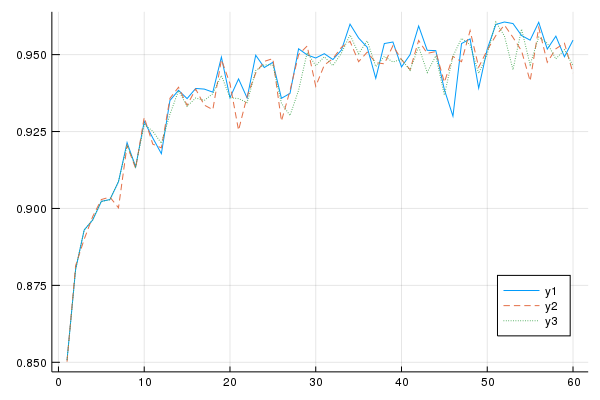

In [22]:
# Plot training curves
Plots.default(fmt=:png,ls=:auto,legend=:bottomright)
plot([r0 r1 r2])